In [1]:
#  Libraries
import tqdm
import numpy as np 
import pandas as pd
from time import time
import datetime as dt
import pickle
import gc
# Data processing, metrics and modeling
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold
from bayes_opt import BayesianOptimization
from sklearn.metrics import precision_score, recall_score, confusion_matrix, accuracy_score, roc_auc_score, f1_score, roc_curve, auc,precision_recall_curve
from sklearn import metrics
from sklearn import preprocessing
# Lgbm
import lightgbm as lgb
# Suppr warning
import warnings
warnings.filterwarnings("ignore")
import json

import itertools
from scipy import interp

# Plots
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import rcParams

In [2]:
#import in dataset
f = open("features_optimized.txt","r")
features_list = []
features_list = f.read().splitlines()
f.close()
print (features_list)

train = pd.read_csv("train_prepared.csv")
test = pd.read_csv("test_prepared.csv")

['TransactionAmt', 'ProductCD', 'card1', 'card2', 'card3', 'card4', 'card5', 'card6', 'addr1', 'dist1', 'P_emaildomain', 'R_emaildomain', 'C1', 'C2', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11', 'C12', 'C13', 'C14', 'D1', 'D2', 'D3', 'D4', 'D5', 'D6', 'D8', 'D9', 'D10', 'D11', 'D12', 'D13', 'D14', 'D15', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V10', 'V11', 'V12', 'V13', 'V19', 'V20', 'V29', 'V30', 'V34', 'V35', 'V36', 'V37', 'V38', 'V40', 'V44', 'V45', 'V47', 'V48', 'V49', 'V52', 'V53', 'V54', 'V56', 'V61', 'V62', 'V63', 'V64', 'V69', 'V70', 'V74', 'V75', 'V76', 'V78', 'V81', 'V82', 'V83', 'V85', 'V87', 'V90', 'V91', 'V94', 'V95', 'V96', 'V99', 'V126', 'V127', 'V128', 'V130', 'V131', 'V139', 'V140', 'V143', 'V149', 'V150', 'V152', 'V156', 'V159', 'V160', 'V164', 'V165', 'V166', 'V170', 'V187', 'V189', 'V202', 'V203', 'V204', 'V205', 'V206', 'V207', 'V208', 'V209', 'V210', 'V212', 'V213', 'V214', 'V215', 'V218', 'V220', 'V221', 'V222', '

In [3]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: 
        print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [4]:
#encode the dataframe
for col in tqdm.tqdm(train.columns): 
    if train[col].dtype == 'object':
        le = LabelEncoder()
        le.fit(list(train[col].astype(str).values) + list(test[col].astype(str).values))
        train[col] = le.transform(list(train[col].astype(str).values))
        test[col] = le.transform(list(test[col].astype(str).values))  

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 355/355 [00:28<00:00, 12.29it/s]


In [5]:
#reduce mem usage
train = reduce_mem_usage(train)
test = reduce_mem_usage(test)

Mem. usage decreased to 425.77 Mb (73.4% reduction)
Mem. usage decreased to 372.56 Mb (72.8% reduction)


In [6]:
#isolate test and traindata
test_data = test[features_list]
train_data = train[features_list]

In [7]:
result_list = test["TransactionID"].to_frame(name="TransactionID")
mydf = train['isFraud']
target = mydf

In [8]:
del(test)
del(train)
gc.collect()

60

In [9]:
#create lgb dataset from train set
# d_train = lgb.Dataset(train_data, label=target)

In [10]:
# #Declare params here
#highest score
params= {'num_leaves': 250,
          'min_child_weight': 0.1,
          'feature_fraction': 0.5,
          'bagging_fraction': 0.5,
          'min_data_in_leaf': 256,
          'bagging_freq': 5,
          'objective': 'binary',
          'max_depth': -1, 
          'learning_rate': 0.001,
          "boosting_type": "gbdt", 
          "bagging_seed": 4041,   
          "feature_fraction_seed":4041, 
          "metric": 'auc',       
          'reg_alpha': 0.,        
          'reg_lambda': 2.,      
         } 
#change to num leaves
params3= {'num_leaves': 250,
          'min_child_weight': 0.1,
          'feature_fraction': 0.5,
          'bagging_fraction': 0.5,
          'min_data_in_leaf': 256,
          'bagging_freq': 5,
          'objective': 'binary',
          'max_depth': -1,
          'learning_rate': 0.1,
          "boosting_type": "gbdt",
          "bagging_seed": 4041,
          "feature_fraction_seed":4041,
          "metric": 'auc',
          'reg_alpha': 1.,
          'reg_lambda': 2.,
         }


paramList = [params]

In [11]:
#catboost params here
#paramList = [params,params1,params2,params3,params4]

In [12]:
#prepare folds for validation
folds = StratifiedKFold(n_splits=5,shuffle=False)

In [13]:
def callTraining(index,train_data,target,folds,params):
    aucs_list = list()
    feature_ranking = pd.DataFrame()
    feature_ranking['feature'] = train_data.columns
    max_rds = []
    training_start_time = time()
    for fold,(trn_idx,test_idx) in enumerate(folds.split(train_data,target)):
        start_time = time()
        print('Training on fold {}'.format(fold+1))
        trn_data = lgb.Dataset(train_data.iloc[trn_idx], label=target.iloc[trn_idx])
        val_data = lgb.Dataset(train_data.iloc[test_idx], label=target.iloc[test_idx])
        lgb_clf = lgb.train(params, trn_data, 25000, valid_sets = [trn_data, val_data], verbose_eval=1000, early_stopping_rounds=100)
        feature_ranking['fold_{}'.format(fold + 1)] = lgb_clf.feature_importance()
        aucs_list.append(lgb_clf.best_score['valid_1']['auc'])
        max_rds.append(lgb_clf.best_iteration)
    print('Fold {} finished in {}'.format(fold + 1, str(dt.timedelta(seconds=time() - start_time))))
    print('-' * 30)
    print('Training has finished.')
    print('Total training time is {}'.format(str(dt.timedelta(seconds=time() - training_start_time))))
    print('Mean AUC:', np.mean(aucs_list))
    print('-' * 30)
    
    feature_ranking['average'] = feature_ranking[['fold_{}'.format(fold + 1) for fold in range(folds.n_splits)]].mean(axis=1)
    feature_ranking.to_csv('feature_importances{}.csv'.format(index))
    best_iter = max(max_rds)
    lgb_clf = lgb.LGBMClassifier(**params, num_boost_round=best_iter)
    lgb_clf.fit(train_data, target)
    filename = 'finalized_model{}.sav'.format(index)
    pickle.dump(lgb_clf, open(filename, 'wb'))
    
    return lgb_clf

In [14]:
def callPredict(lgb_clf, test_data,result_list, index):
    y_pred = lgb_clf.predict_proba(test_data)[:, 1]#convert into binary values
    result_list["isFraud"] = y_pred
    results = result_list
    results.to_csv("LGBPredictions{}.csv".format(index),index=False)

Testing model 1
Training on fold 1
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[180]	training's auc: 0.993343	valid_1's auc: 0.905602
Training on fold 2
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[265]	training's auc: 0.996927	valid_1's auc: 0.931783
Training on fold 3
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[170]	training's auc: 0.992663	valid_1's auc: 0.92219
Training on fold 4
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[149]	training's auc: 0.989927	valid_1's auc: 0.942203
Training on fold 5
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[110]	training's auc: 0.984853	valid_1's auc: 0.916558
Fold 5 finished in 0:00:26.600613
------------------------------
Training has finished.
Total training time is 0:02:44.817147
Mean

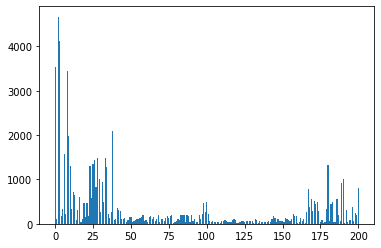

In [15]:
for index in range(len(paramList)):
    print("Testing model {}".format(str(index+1)))
    trained_model = callTraining(index, train_data,target,folds,paramList[index])
    result_copy = result_list.copy()
    callPredict(trained_model,test_data,result_copy,index)
    f = open("params_file.txt","a")
    f.write(json.dumps(paramList[index])+'\n')
    f.close()
    plt.bar(range(len(trained_model.feature_importances_)), trained_model.feature_importances_)